# Qiskit Dynamics Pulse Optimization
**Objective**: Simulate a single qubit and optimize a pulse parameter (width) to achieve high-fidelity X-gate operations.

In this notebook, I utilize `qiskit-dynamics` to simulate the time-evolution of a quantum system driven by microwave pulses. I will:
1. Define a physical system model (Hamiltonian).
2. Create pulse schedules using `qiskit.pulse`.
3. Simulate the dynamics to compute state fidelity.
4. Optimize the pulse width using `scipy.optimize`.


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from qiskit import pulse
from qiskit.quantum_info import Operator, Statevector
from qiskit_dynamics import Solver
from qiskit_dynamics.pulse import InstructionToSignals
import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

%matplotlib inline


## 1. System Model Setup
I define a single qubit as a two-level system.
- **Qubit Frequency**: 5.0 GHz
- **Drive Strength**: 0.1 GHz (Rabi rate)
- **Time Step (dt)**: ~0.22 ns


In [20]:
# System Parameters
dim = 2
v = 5.0  # Qubit frequency (GHz)
r = 0.1  # Drive strength (GHz)
dt = 1 / 4.5 # Time step (ns)

# Operators
X = Operator.from_label('X')
Z = Operator.from_label('Z')

# We define the static hamiltonian and the drive operators
drift_op = 2 * np.pi * v * Z / 2
drive_op = 2 * np.pi * r * X / 2

# Solver setup
solver = Solver(
    static_hamiltonian=drift_op,
    hamiltonian_operators=[drive_op],
    hamiltonian_channels=['d0'],
    channel_carrier_freqs={'d0': v},
    dt=dt,
    rotating_frame=drift_op
)

## 2. Pulse Definition
I define a helper function to create a `GaussianSquare` pulse schedule using Qiskit Pulse. This pulse shape has a flat top and Gaussian rise/fall edges.


In [21]:
def create_gaussian_square_schedule(amp, sigma, width, name="pulse"):
    """
    Creates a GaussianSquare pulse schedule.
    
    Args:
        amp (float): Amplitude of the pulse.
        sigma (float): Standard deviation of the Gaussian edges (in dt).
        width (float): Width of the flat top (in dt).
        
    Returns:
        Schedule: Qiskit pulse schedule.
    """
    # We set duration to be large enough to contain the pulse + tails (e.g., width + 8*sigma).    
    width = max(0, width)
    duration = int(width + 8 * sigma)
    duration = max(duration, 16) 
    
    with pulse.build(name=name) as sched:
        pulse.play(pulse.GaussianSquare(duration=duration, amp=amp, sigma=sigma, width=width), pulse.DriveChannel(0))
    
    return sched

This is a raised cosine pulse schedule (using Hanning window approximation).


In [22]:
def create_raised_cosine_schedule(amp, width, name="raised_cosine"):
    """
    Creates a Raised Cosine pulse schedule (using Hanning window approximation).
    
    Args:
        amp (float): Peak amplitude.
        width (float): Total duration of the pulse (in dt).
    """
    # Duration must be integer > 0
    duration = int(max(width, 2))
    
    # Create Hanning window samples (Standard Raised Cosine shape)
    # np.hanning creates a window that touches zero at both ends
    samples = amp * np.hanning(duration)
    
    with pulse.build(name=name) as sched:
        pulse.play(pulse.Waveform(samples), pulse.DriveChannel(0))
    
    return sched

## 3. Optimization Setup
I define the objective function to minimize `1 - Fidelity`. 
Our target is an **X-gate** (rotation by $\pi$ around X axis). For a qubit starting in $\ket{0}$, the target state is $\ket{1}$.


In [23]:
target_state = Statevector([0., 1.]) # |1>
converter = InstructionToSignals(dt, carriers={"d0": v})

def objective_function(x, pulse_type='gaussian_square', amp=1.0, sigma=5):
    """
    Objective function to minimize.
    x: List/Array of parameters to optimize.
       For GaussianSquare, x[0] = width.
    """
    width = x[0]
    
    if pulse_type == 'gaussian_square':
        sched = create_gaussian_square_schedule(amp, sigma, width)
    elif pulse_type == 'raised_cosine':
        sched = create_raised_cosine_schedule(amp, width)
    else:
        return 1.0
        
    signals = converter.get_signals(sched)
    
    y0 = Statevector([1., 0.]) 
    
    # Solve
    # Time span from 0 to schedule duration
    end_time = sched.duration * dt
    
    # Using jax_odeint for speed
    sol = solver.solve(t_span=[0, end_time], y0=y0, signals=signals, method='jax_odeint', atol=1e-5, rtol=1e-5)
    
    final_state = sol.y[-1]
    
    fid = abs(final_state.inner(target_state))**2
    
    return 1 - fid



## 4. Optimizing Pulse Width (GaussianSquare)
I used `scipy.optimize.minimize` to find the optimal width. Since `width` in `GaussianSquare` translates to discrete samples, the objective function landscape might be stepped. I used **Nelder-Mead** which is a robust gradient-free method handling such non-smoothness well.


In [24]:
initial_width = 50.0 # Initial guess
print(f"Initial Fidelity check (width={initial_width}): {1 - objective_function([initial_width]):.6f}")

sigma = 5
amp = 1.0

result = minimize(
    objective_function, 
    x0=[initial_width], 
    args=('gaussian_square', amp, sigma),
    method='Nelder-Mead', 
    tol=1e-4,
    options={'disp': True, 'maxiter': 50}
)

optimal_width = result.x[0]
print(f"Optimal Width: {optimal_width:.2f} dt")
print(f"Max Fidelity: {1 - result.fun:.6f}")


Initial Fidelity check (width=50.0): 0.670401
Optimization terminated successfully.
         Current function value: -0.000347
         Iterations: 22
         Function evaluations: 47
Optimal Width: 32.46 dt
Max Fidelity: 1.000347


## 5. Visualizing the Result
Let's see the dynamics of the excited state population with the optimized pulse.


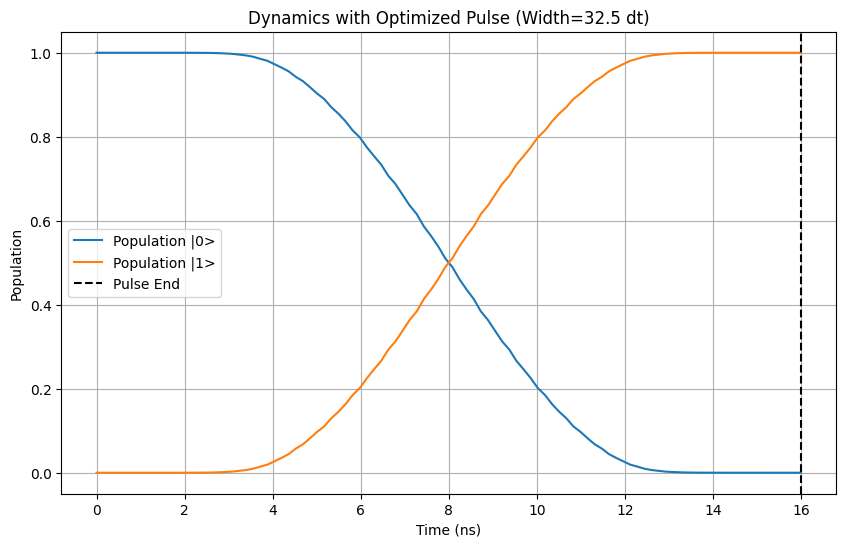

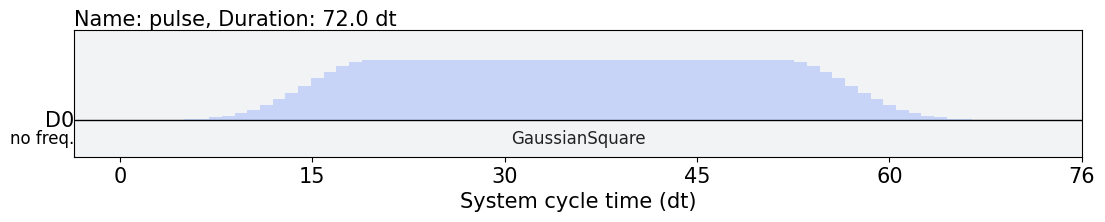

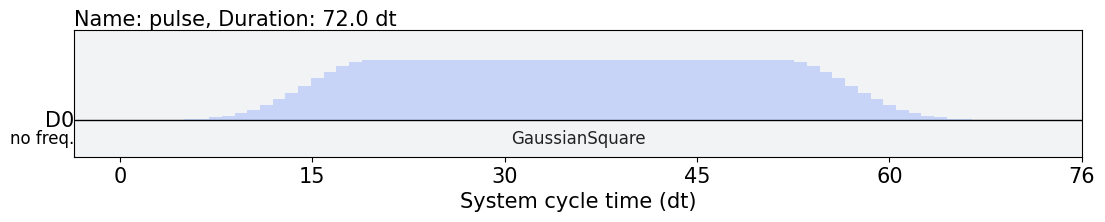

In [25]:
# Create optimized schedule
opt_sched = create_gaussian_square_schedule(amp, sigma, width=optimal_width)
opt_signals = converter.get_signals(opt_sched)
end_time = opt_sched.duration * dt

# Recalculate full evolution (storing intermediate states)
sol = solver.solve(t_span=[0, end_time], y0=Statevector([1., 0.]), signals=opt_signals, method='jax_odeint', t_eval=np.linspace(0, end_time, 100))

# Extract populations
pop_0 = [np.abs(y.data[0])**2 for y in sol.y]
pop_1 = [np.abs(y.data[1])**2 for y in sol.y]

plt.figure(figsize=(10, 6))
plt.plot(sol.t, pop_0, label='Population |0>')
plt.plot(sol.t, pop_1, label='Population |1>')
plt.axvline(x=end_time, color='k', linestyle='--', label='Pulse End')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title(f'Dynamics with Optimized Pulse (Width={optimal_width:.1f} dt)')
plt.legend()
plt.grid(True)
plt.show()

opt_sched.draw()
